In [141]:
#importing Dependencies
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Loading Dataset

In [120]:
# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.to_numpy(), mnist.target.astype(int).to_numpy()

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
mnist.data.columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

In [122]:
X_train.shape

(56000, 784)

Normalizing

In [123]:
# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

In [124]:
X_train.shape

(56000, 784)

One hot Encoding Target

In [125]:
#Since the output layer has 10 nodes. we will perform ohe here
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_onehot = one_hot(y_train)
y_test_onehot = one_hot(y_test)

Initialize Parameters

In [126]:
def initialize_parameters():
    np.random.seed(42)
    W1 = np.random.randn(128, 784) * 0.01  # Small random values to avoid symmetry
    b1 = np.zeros((128, 1))                # Bias initialized to 0
    W2 = np.random.randn(10, 128) * 0.01
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

Implementing Forward Propogation

In [127]:
def relu(Z):
    return np.maximum(0, Z)

def softmax(Z):
    # Numerically stable softmax
    Z_exp = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return Z_exp / np.sum(Z_exp, axis=0, keepdims=True)

def forward_pass(X, W1, b1, W2, b2):
    # Input to hidden layer
    Z1 = np.dot(W1, X.T) + b1  # Shape: (128, m)
    A1 = relu(Z1)
    
    # Hidden to output layer
    Z2 = np.dot(W2, A1) + b2   # Shape: (10, m)
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

Loss calculation

In [128]:
def compute_loss(A2, Y):
    m = Y.shape[0]
    return -np.sum(Y * np.log(A2.T + 1e-8)) / m  # Add 1e-8 to avoid log(0)

Backward Propogation

In [129]:
def backward_pass(X, Y, Z1, A1, A2, W2):
    m = X.shape[0]
    
    # Output layer gradient
    dZ2 = A2 - Y.T  # Shape: (10, m)
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m
    
    # Hidden layer gradient
    dZ1 = np.dot(W2.T, dZ2) * (Z1 > 0)  # ReLU derivative
    dW1 = np.dot(dZ1, X) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m
    
    return dW1, db1, dW2, db2

Updating Parameters

In [130]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    return W1, b1, W2, b2

Training Loop

In [131]:
def train(X_train, y_train_onehot, epochs=20, alpha=0.01, batch_size=64):
    W1, b1, W2, b2 = initialize_parameters()
    
    for epoch in range(epochs):
        # Shuffle data
        permutation = np.random.permutation(X_train.shape[0])
        X_shuffled = X_train[permutation]
        y_shuffled = y_train_onehot[permutation]
        
        # Mini-batch gradient descent
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward pass
            Z1, A1, Z2, A2 = forward_pass(X_batch, W1, b1, W2, b2)
            
            # Compute loss
            loss = compute_loss(A2, y_batch)
            
            # Backward pass
            dW1, db1, dW2, db2 = backward_pass(X_batch, y_batch, Z1, A1, A2, W2)
            
            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        
        # Print loss every epoch
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
    
    return W1, b1, W2, b2

In [133]:
W1, b1, W2, b2 = train(X_train, y_train_onehot)

Epoch 1/20, Loss: 1.1077
Epoch 2/20, Loss: 0.5701
Epoch 3/20, Loss: 0.5198
Epoch 4/20, Loss: 0.2536
Epoch 5/20, Loss: 0.3757
Epoch 6/20, Loss: 0.2537
Epoch 7/20, Loss: 0.3051
Epoch 8/20, Loss: 0.2985
Epoch 9/20, Loss: 0.2334
Epoch 10/20, Loss: 0.2037
Epoch 11/20, Loss: 0.3080
Epoch 12/20, Loss: 0.2455
Epoch 13/20, Loss: 0.2449
Epoch 14/20, Loss: 0.2441
Epoch 15/20, Loss: 0.1326
Epoch 16/20, Loss: 0.2819
Epoch 17/20, Loss: 0.4067
Epoch 18/20, Loss: 0.1208
Epoch 19/20, Loss: 0.0875
Epoch 20/20, Loss: 0.3829


In [134]:
def predict(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_pass(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=0)

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Test set predictions
y_pred_test = predict(X_test, W1, b1, W2, b2)
test_acc = accuracy(y_test, y_pred_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 93.76%


Testing Model with Some Test Data

Example1

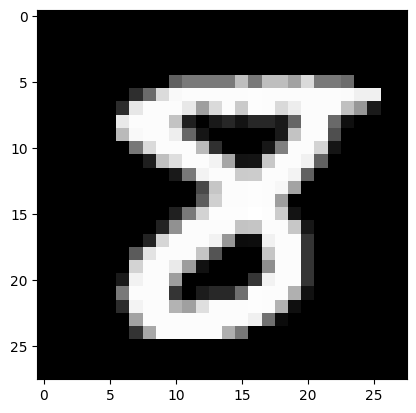

In [135]:
plt.imshow(X_test[0].reshape(28,28), cmap = 'gray')

In [136]:
predict(X_test[0].reshape(1,-1), W1, b1, W2, b2)

array([8], dtype=int64)

Example2

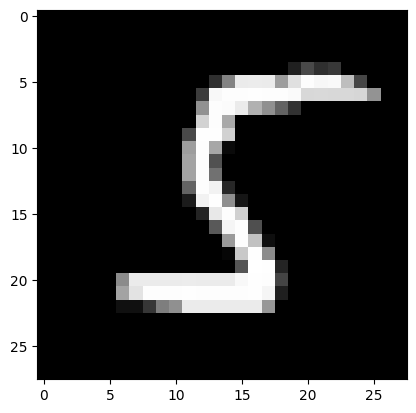

In [137]:
plt.imshow(X_test[45].reshape(28,28), cmap = 'gray')

In [138]:
predict(X_test[45].reshape(1,-1), W1, b1, W2, b2)

array([5], dtype=int64)

Example3

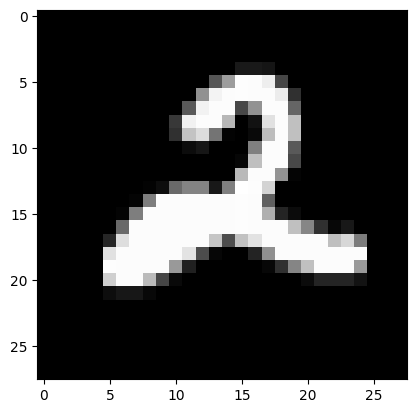

In [139]:
plt.imshow(X_test[1001].reshape(28,28), cmap = 'gray')

In [140]:
predict(X_test[1001].reshape(1,-1), W1, b1, W2, b2)

array([2], dtype=int64)